### Calculate the policy of the agent
* State Variable: x = [w, n_lag, h_lag, e, s, A], action variable a = [c, b, k, h], both of them are numpy array 

In [4]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as RS
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
import warnings
from scipy import optimize

warnings.filterwarnings("ignore")
np.printoptions(precision=2)
# time line
T_min = 0
T_max = 70
T_R = 45
beta = 1/(1+0.02)
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
# expected return on stock market 
r_bar = 0.0667
# probability of survival
Pa = np.load("prob.npy")
# probability of employment transition 
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# deterministic income
detEarning = np.load("detEarning.npy")
# tax rate 
tau_L = 0.2
tau_R = 0.1
# minimum consumption
c_bar = 3

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Define the new utility function as a funciton of consumption good cost and renting
def u(c, h):
    alpha = 0.88
    kappa = 0
    gamma = 2
    ch = np.float_power(max(c-c_bar,0),alpha) * np.float_power((1+kappa)*h,1-alpha)
    return (np.float_power(ch,1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    gamma = 2
    return B*(np.float_power(max(w,0),1-gamma) - 1)/(1 - gamma)

#Define the earning function 
def y(t, x):
    w, n, h_lag, s, e, A = x
    if A == 0:
        return 0
    else:
        if t <= T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e)*5
        else:
            return detEarning[t]

# Define the reward funtion
def R(x, a):
    c, b, k, h = a
    w, n, h_lag, s, e, A = x
    if A == 0:
        return uB(w+n)
    else:
        return u(c,h)

# Define the transtiion of state (test)
def transition(x, a, t):
    '''
        Input: x current state: (w, n, h_lag, e, s, A) 
               a action taken: (c, b, k, h)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k, h = a
    w, n, h_lag, s, e, A = x
    
    x_next = []
    prob_next = []
    # Agent is dead 
    if A == 0:
        for s_next in [0, 1]:
            x_next.append([0, 0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    else:
        # after retirement calculate the annuity payment
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        # A = 1, agent is still alive and for the next period
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+0.02)
            else:
                n_next = n*(1+0.02)
        else:
            n_next = n*(1+0.02)-n/discounting
            
        for s_next in [0, 1]:
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            
            for e_next in [0,1]:
                for A_next in [0,1]:
                    if A_next == 0:
                        x_next.append([w_next, n*(1+0.02), h, s_next, 0, 0])
                    else:
                        # Age reaches 65 or agent is dead directly results in unemployment
                        if t >= T_R:
                            x_next.append([w_next, n_next, h, s_next, 0, 1])
                        else:
                            x_next.append([w_next, n_next, h, s_next, e_next, 1])
                    prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
        return np.array(x_next), np.array(prob_next) 
    
    
# Value function is a function of state and time t
def V(x, t, Vmodel):
    # Define the objective function as a function of action
    potentialH = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    w, n, h_lag, s, e, A = x
    if A == 0:
        return np.array([R(x,[0,0,0,0]),[0,0,0,0]])
    else: 
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        pr = 2
        ytx = y(t, x)
        def obj(thetas, h):
            theta1, theta2 = thetas
            if t < T_R:
                if e == 1:
                    bk = ((1-tau_L)*(ytx * 0.95) + w) * theta1
                    ch = ((1-tau_L)*(ytx * 0.95) + w) *(1-theta1)
                else:
                    bk = ((1-tau_L)*ytx + w) * theta1
                    ch = ((1-tau_L)*ytx + w) * (1-theta1)
            else:
                bk = ((1-tau_R)*ytx + w + n_discount) * theta1
                ch = ((1-tau_R)*ytx + w + n_discount) * (1-theta1)
                
            b = bk * theta2
            k = bk * (1-theta2)
            c = ch - pr*h - 5*(h != h_lag)
            if c <= c_bar:
                return 999999999
            a = (c,b,k,h)
            x_next, prob_next = transition(x, a, t)
            return -(R(x, a) + beta * np.dot(Vmodel[int(s)][int(e)][int(A)](x_next[:,:3]), prob_next))
        
        xopts = []
        fopts = []
        for hval in potentialH:
            xopt, fopt = pso(partial(obj, h = hval), lb=[0,0,0], ub =[1,1,1], swarmsize = 60)
            xopts.append(xopt)
            fopts.append(-fopts)
        
        index = np.argmax(fopts)
        max_val = fopts[index]
        theta1_m, theta2_m = xopts[index]
        h_m = potentialH[index]
        
        if t < T_R:
            if e == 1:
                bk_m = ((1-tau_L)*(ytx * 0.95) + w) * theta1_m
                ch_m = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1_m)
            else:
                bk_m = ((1-tau_L)*ytx + w) * theta1_m
                ch_m = ((1-tau_L)*ytx + w) * (1-theta1_m)
                
        else:
            bk_m = ((1-tau_R)*ytx + w + n_discount) * theta1_m
            ch_m = ((1-tau_R)*ytx + w + n_discount) * (1-theta1_m)
            
        b_m = bk_m * theta2_m
        k_m = bk_m * (1-theta2_m)
        c_m = ch_m - pr*h_m - 5*(h_m != h_lag)
        return np.array([max_val, [c_m, b_m, k_m, h_m]])

In [6]:
# wealth discretization 
w_grid_size = 50
w_lower = 5
w_upper = 20000
# 401k amount discretization 
n_grid_size = 10
n_lower = 5
n_upper = 20000
# housing consumption discretization
h_grid = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
h_grid_size = 11 

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

# initialize the state discretization 
x_T = np.array([[w,n,h_lag,e,s,0]   for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for h_lag in h_grid
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, h_grid_size, 2,2,2,6))

xgrid = np.array([[w,n,h_lag,e,s,A] for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for h_lag in h_grid
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, h_grid_size, 2,2,2,6))

Vgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))
hgrid = np.zeros((w_grid_size, n_grid_size, h_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = xgrid):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * h_grid_size* 2 * 2 * 2, 6))))).reshape((w_grid_size, n_grid_size,h_grid_size,2,2,2))

Vgrid[:,:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0,0]), x = x_T)

### Backward Induction Part

69


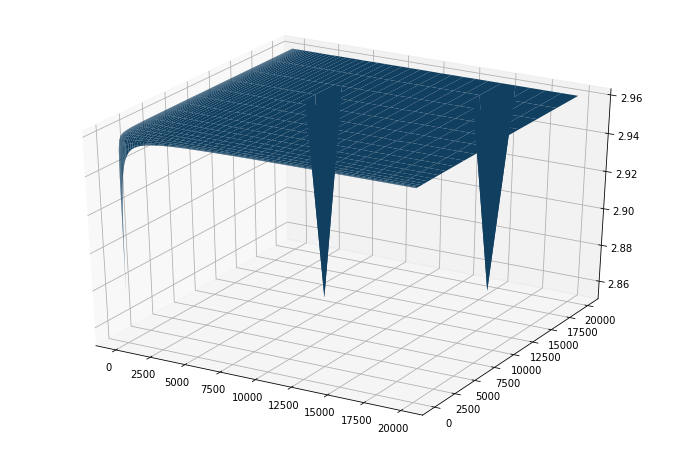

68


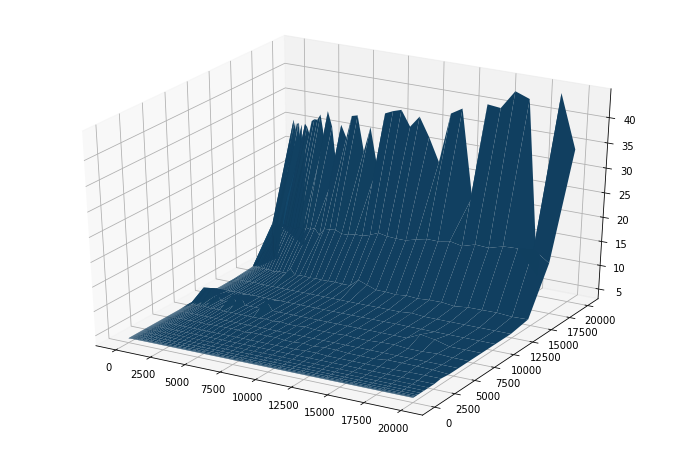

67


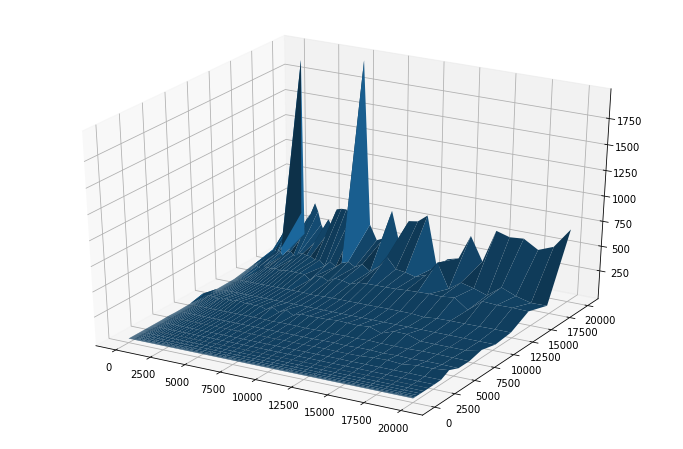

66


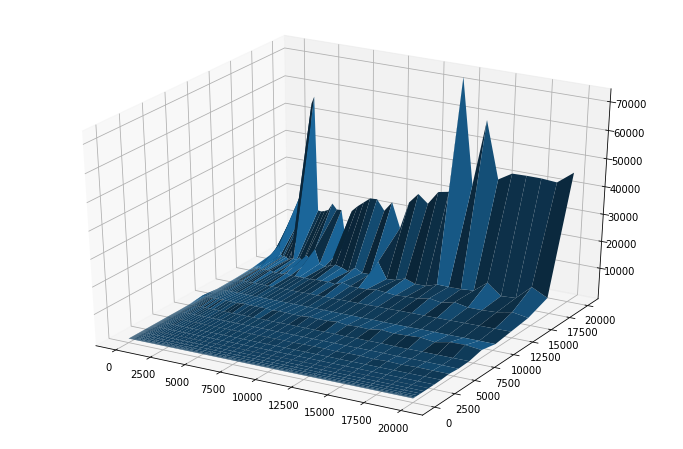

CPU times: user 1min 4s, sys: 14.6 s, total: 1min 18s
Wall time: 1h 29min 13s


In [4]:
%%time 
ws = powspace(w_lower, w_upper, 3, w_grid_size)
ns = powspace(n_lower, n_upper, 3, n_grid_size)
hs = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

xs = xgrid.reshape((w_grid_size * n_grid_size * h_grid_size * 2 * 2 * 2, 6))

pool = Pool()

for t in range(T_max-1, T_max-5, -1):
    print(t)
    cs = [[[RS((ws, ns, hs), Vgrid[:,:,:,s,e,A,t+1],bounds_error=False, fill_value= None) for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs)
    results = np.array(pool.map(f, xs))   
    Vgrid[:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,h_grid_size, 2,2,2))
    #########################################################[test function part] 
    fig = plt.figure(figsize = [12, 8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = xgrid[:,:,0,1,1,1,0], Y = xgrid[:,:,0,1,1,1,1], Z=Vgrid[:,:,0,1,1,1,t])
    plt.show()
    #########################################################
    cgrid[:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    bgrid[:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    kgrid[:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
    hgrid[:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size, n_grid_size, h_grid_size,2,2,2))
pool.close()

In [5]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, V = Vgrid, C = cgrid, B = bgrid, K = kgrid):
    plt.figure(figsize = [12,8])
    plt.plot(list(range(20,91)), cgrid[w_level, n_level, s,e,A,:], label= "Consumption")
    plt.plot(list(range(20,91)), bgrid[w_level, n_level, s,e,A,:], label= "Bond Holding")
    plt.plot(list(range(20,91)), kgrid[w_level, n_level, s,e,A,:], label= "Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(50, 0, 1, 1)

TypeError: summaryPlotChoiceVStime() missing 1 required positional argument: 'A'

In [ ]:
def summaryPlotWealthVSChoice(t, s, e, A, V = Vgrid, C = cgrid, B = bgrid, K = kgrid):
    plt.figure(figsize = [12,8])
    plt.plot(ws, cgrid[:,s,e,A,t], label="Consumption")
    plt.plot(ws, bgrid[:,s,e,A,t], label="Bond Holding")
    plt.plot(ws, kgrid[:,s,e,A,t], label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotWealthVSChoice(60, 0, 1, 1)

### Simulation Part

In [ ]:
import quantecon as qe
mc = qe.MarkovChain(Ps)

def action(t, x):
    w,s,e,A = x
    if A == 1:
        c = interp1d(ws, cgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
        b = interp1d(ws, bgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
        k = interp1d(ws, kgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
    else:
        c = 0
        b = 0
        k = 0
    return (c,b,k)

# Define the transtiion of state 
def transition(x, a, t, s_next):
    '''
        Input: x current state: (w, n, s, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    w, s, e, A = x
    
    x_next = []
    prob_next = []
    if A == 0:
        return [0, s_next, 0, 0]
    else:
        # A = 1, agent is still alive and for the next period
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        r_stock = r_m[int(s), s_next]
        w_next =  b*(1+r_bond) + k*(1+r_stock)
        for e_next in [0,1]:
            for A_next in [0,1]:
                x_next.append([w_next, s_next, e_next, A_next])
                prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(4, 1, p = prob_next)[0]]

In [ ]:
def simulation(num):
    for sim in range(num):
        if sim%100 == 0:
            print(sim)
        # simulate an agent age 15 starting with wealth of 10
        w = 20
        wealth = []
        Consumption = []
        Bond = []
        Stock = []
        Salary = []
        econState = mc.simulate(ts_length=T_max - T_min)
        alive = True
        for t in range(len(econState)-1):
            if rd.random() > prob[t]:
                alive = False
            wealth.append(w)
            s = econState[t]
            s_next = econState[t+1]
            a = action(t, w, s, alive)
            if alive:
                Salary.append(y(t+T_min, s))
            else:
                Salary.append(0)
            Consumption.append(a[0])
            Bond.append(a[1])
            Stock.append(a[2])
            w = fixTransition(w,s,s_next, a, alive)
        # dictionary of lists  
        dictionary = {'wealth': wealth,
                      'Consumption': Consumption, 
                      'Bond': Bond, 
                      'Stock': Stock,
                      'Salary': Salary}
        if sim == 0:
            df = pd.DataFrame(dictionary) 
        else:
            df = df + pd.DataFrame(dictionary)           
    return df/num 

In [ ]:
# simulate an agent age 0 starting with wealth of 70
econState = mc.simulate(ts_length=T_max - T_min)
def simulateAgent(sim):
    wealth = []
    Consumption = []
    Bond = []
    Stock = []
    Salary = []
    employ = []
    live = []
    x = [20, 0, 0, 1]
    for t in range(len(econState)-1):
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, x)
        c, b, k = a
        w,_,e,A = x
        
        wealth.append(w)
        Consumption.append(c)
        Bond.append(b)
        Stock.append(k)
        Salary.append(y(t, x))
        employ.append(e)
        live.append(A)
        x = transition(x, a, t, s_next)
    # dictionary of lists  
    dictionary = {'wealth': wealth,
                  'Consumption': Consumption, 
                  'Bond': Bond, 
                  'Stock': Stock,
                  'Salary': Salary,
                  'employ': employ,
                  'live': live}
    return pd.DataFrame(dictionary)

In [ ]:
pool = Pool()
sim = 10000
agents = pool.map(simulateAgent, list(range(sim)))
pool.close()

In [ ]:
df = pd.DataFrame()
for agent in agents:
    if df.size == 0:
        df = agent
    else:
        df = df + agent
df = df/sim

In [ ]:
df = df/10000

In [ ]:
df.plot()

In [ ]:
df[["wealth","Consumption","Bond","Stock"]].plot()